Tracking Breakers

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import signal
import scipy.fft as fft
import cftime
import netCDF4 as nc
from scipy.signal import blackman
from scipy import interpolate
%matplotlib widget

In [1]:
def computeAlpha(time, xaccel, yaccel, zaccel):
    # Define spectral parameters
    # See Brown et al. 2019 for more details
    samples_per_window = int(32)     #number of samples in each window, 2^5 (~2.66 seconds)
    sampling_freq = 12 # Sampling frequency, units are Hz

    # Split signals into windows of given window length
    num_windows = int(np.floor(xaccel.shape[0]/samples_per_window))
    end_index = int(num_windows * samples_per_window)
    alpha_time_windows = time[:end_index].reshape((samples_per_window, num_windows), order='F')
    alpha_time = np.median(alpha_time_windows, axis=0)
    xaccel_windowed = xaccel[:end_index].reshape((samples_per_window, num_windows), order='F')
    yaccel_windowed = yaccel[:end_index].reshape((samples_per_window, num_windows), order='F')
    zaccel_windowed = zaccel[:end_index].reshape((samples_per_window, num_windows), order='F')

    # Compute Blackman Taper window and apply to each window then fft
    blackman_window = blackman(samples_per_window)
    frequency_array = fft.fftfreq(samples_per_window, d=(1/sampling_freq))
    high_freq_ind = np.argwhere(np.abs(frequency_array) >= 2) # all frequnecy indices greater than or equal to 2 Hz
    alpha = []
    for n in np.arange(num_windows):
        # Apply blackman taper
        xaccel_tapered = xaccel_windowed[:,n] * blackman_window
        yaccel_tapered= yaccel_windowed[:,n] * blackman_window
        zaccel_tapered = zaccel_windowed[:,n] * blackman_window

        # Compute fft from windowed and tapered accelerations
        if np.sum(np.isnan(xaccel_tapered))/xaccel_tapered.shape[0] > 0.2:
            alpha.append(0)
            continue

        else:
            # Compute x alpha
            xaccel_inds_nan = np.isnan(xaccel_tapered)
            xaccel_tapered_interp = np.interp(alpha_time_windows[:,n], np.squeeze(alpha_time_windows[~xaccel_inds_nan,n]), np.squeeze(xaccel_tapered[~xaccel_inds_nan]))
            xaccel_windowed_fft = np.abs(fft.fft(xaccel_tapered_interp, norm='forward'))
            x_alpha = np.sum(xaccel_windowed_fft[high_freq_ind])

            # Compute y alpha
            yaccel_inds_nan = np.isnan(yaccel_tapered)
            yaccel_tapered_interp = np.interp(alpha_time_windows[:,n], alpha_time_windows[~yaccel_inds_nan,n], yaccel_tapered[~yaccel_inds_nan])
            yaccel_windowed_fft = np.abs(fft.fft(yaccel_tapered_interp, norm='forward'))
            y_alpha = np.sum(yaccel_windowed_fft[high_freq_ind])

            # Compute z alpha
            zaccel_inds_nan = np.isnan(zaccel_tapered)
            zaccel_tapered_interp = np.interp(alpha_time_windows[:,n], alpha_time_windows[~zaccel_inds_nan,n], zaccel_tapered[~zaccel_inds_nan])
            zaccel_windowed_fft = np.abs(fft.fft(zaccel_tapered_interp, norm='forward'))
            z_alpha = np.sum(zaccel_windowed_fft[high_freq_ind])

            alpha.append(x_alpha + y_alpha + z_alpha)
            
    return np.array(alpha), alpha_time

/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-1.0831855469376999
-1.0831855469376999
-0.8632611364057999


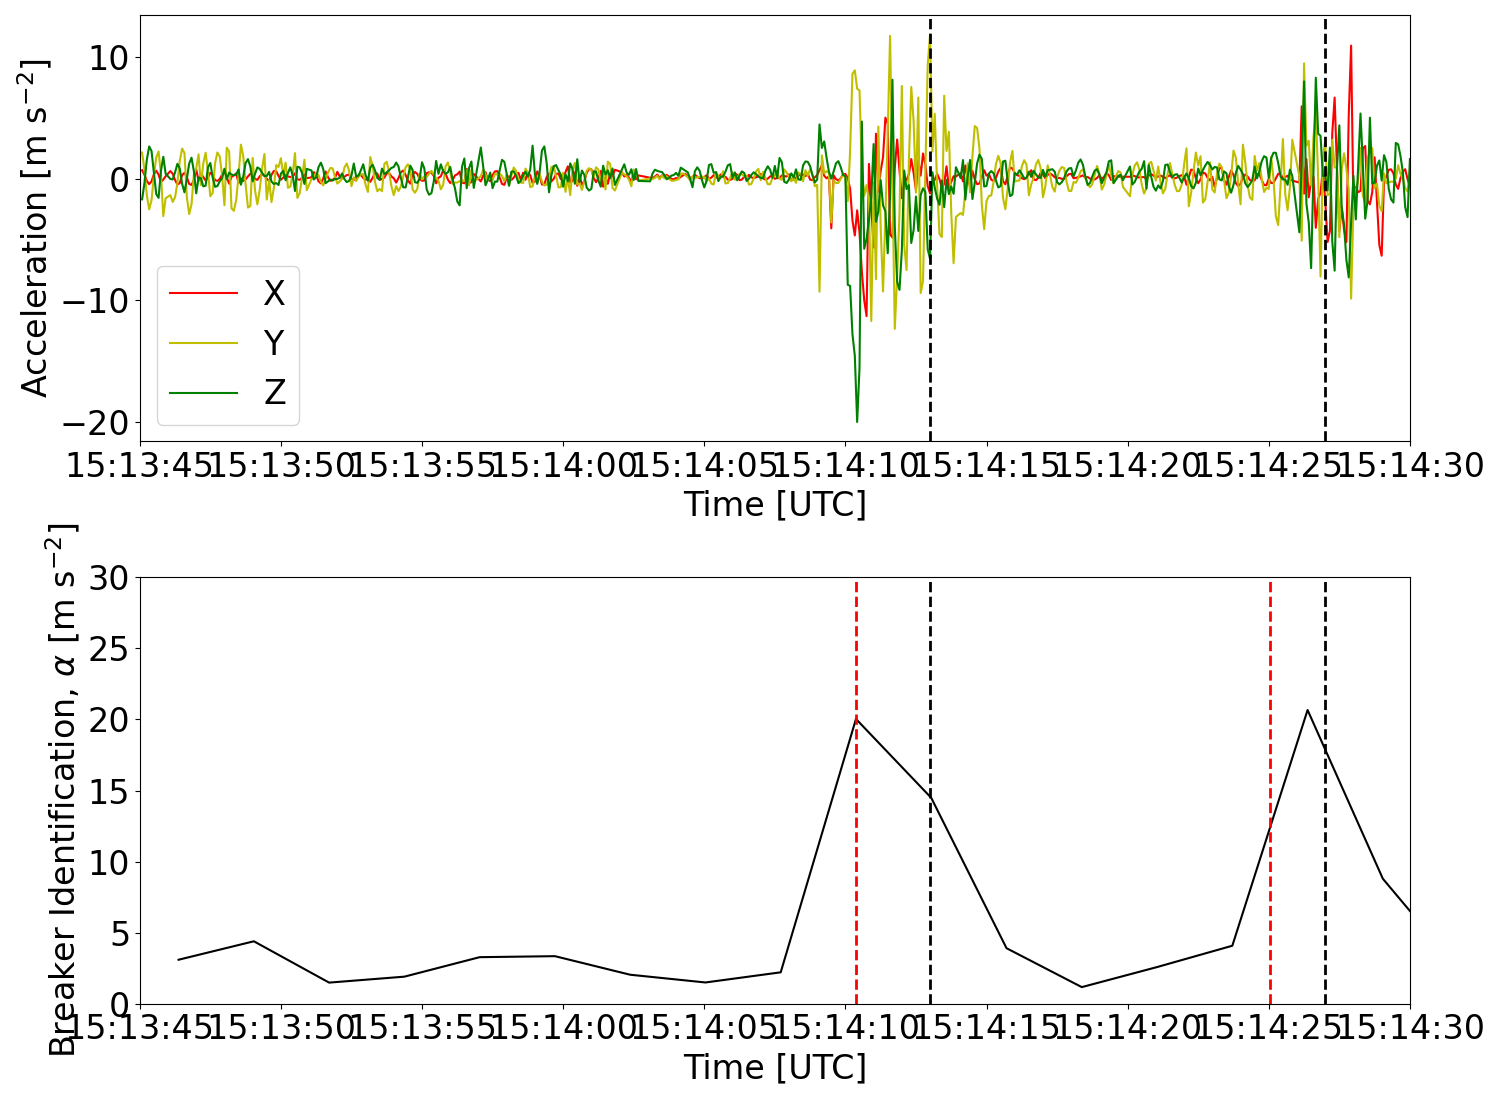

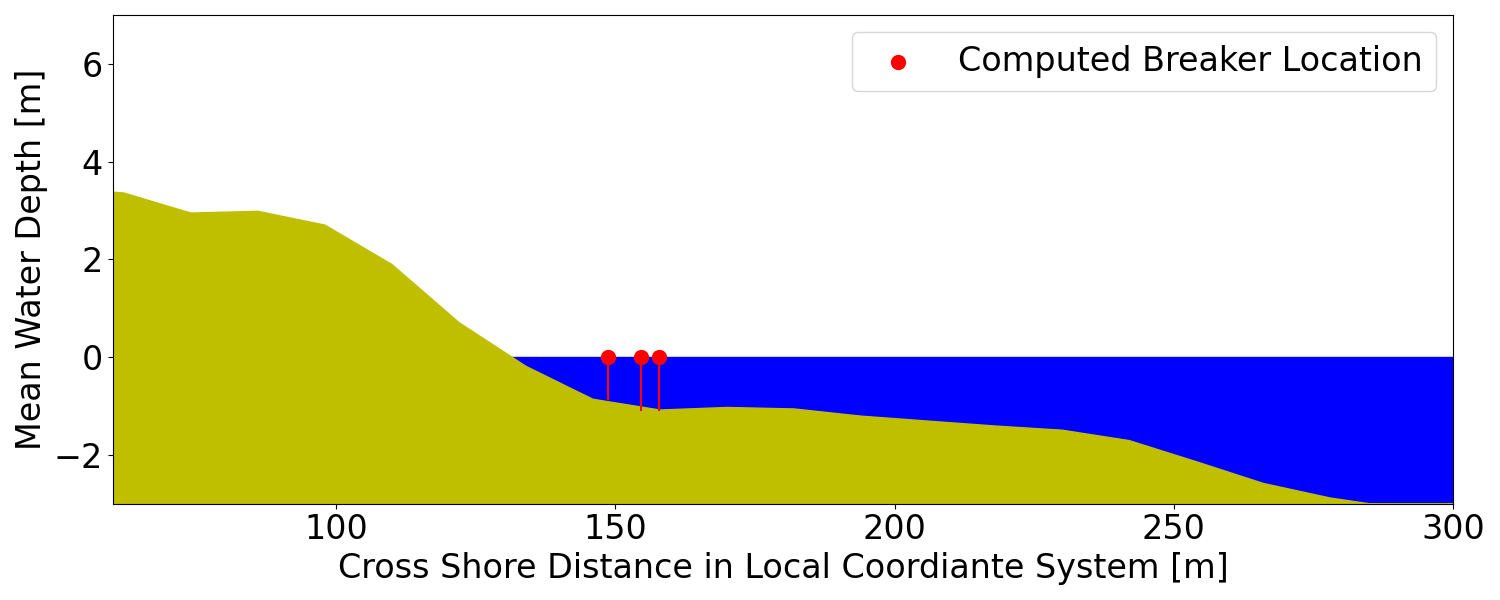

In [12]:
# Define the mission Dataset
mission_dataset = nc.Dataset('../microSWIFT_data/cleanedDataset/mission_52.nc') 
tstart = datetime.datetime(2021, 10, 22, 15, 13, 45)
tend = datetime.datetime(2021, 10, 22, 15, 15, 00)

# Define microSWIFT that we are interested in - microSWIFT_40
microSWIFT= 'microSWIFT_40'
time = cftime.num2pydate(mission_dataset['time'],units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
indicesOfInterest = np.where((np.asarray(time)>tstart) & (np.asarray(time)<tend))[0]
time = time[indicesOfInterest]
xaccel = mission_dataset[microSWIFT]['accel_x'][indicesOfInterest] - np.nanmean(mission_dataset[microSWIFT]['accel_x'][indicesOfInterest]) 
yaccel = mission_dataset[microSWIFT]['accel_y'][indicesOfInterest] - np.nanmean(mission_dataset[microSWIFT]['accel_y'][indicesOfInterest])
zaccel = mission_dataset[microSWIFT]['accel_z'][indicesOfInterest] - np.nanmean(mission_dataset[microSWIFT]['accel_z'][indicesOfInterest])

# Define times when microSWIFT was in a breaker based on hand written notes
breaking_tinds = np.array([datetime.datetime(2021, 10, 22, 15, 14, 13), datetime.datetime(2021, 10, 22, 15, 14, 27), 
                        datetime.datetime(2021, 10, 22, 15, 14, 45), datetime.datetime(2021, 10, 22, 15, 15, 8)])

# Compute Alpha parameter from acceleration signals
alpha, alpha_time = computeAlpha(mission_dataset['time'][indicesOfInterest], xaccel, yaccel, zaccel)

# Convert alpha time to datetimes
alpha_time_datetime = cftime.num2pydate(alpha_time, units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)

# Compute the breaking time from alpha parameters
breaking_threshold = 10  # Threshhold for alpha parameter to signify breaking, units are m/s^2
threshold_crossings = np.diff(alpha > breaking_threshold)
upcrossing_inds = np.argwhere(threshold_crossings)[::2,0]
downcrossing_inds = np.argwhere(threshold_crossings)[1::2,0]
breaker_1_time = datetime.datetime.fromtimestamp((alpha_time_datetime[upcrossing_inds[0]].timestamp() + alpha_time_datetime[downcrossing_inds[0]].timestamp()) / 2 )
breaker_2_time = datetime.datetime.fromtimestamp((alpha_time_datetime[upcrossing_inds[1]].timestamp() + alpha_time_datetime[downcrossing_inds[1]].timestamp()) / 2 )
breaker_3_time = datetime.datetime.fromtimestamp((alpha_time_datetime[upcrossing_inds[2]].timestamp() + alpha_time_datetime[downcrossing_inds[2]].timestamp()) / 2 )

# Plot the acceleration signals
fontsize=24
fig_micro_1, (ax1, ax2) = plt.subplots(figsize=(15,11), nrows=2)
# plot time series with breakers
ax1.plot(time, xaccel, color='r', label='X')
ax1.plot(time, yaccel, color='y', label='Y')
ax1.plot(time, zaccel, color='g', label='Z')
ax1.axvline(breaking_tinds[0], linestyle='--', color='k', linewidth=2)
ax1.axvline(breaking_tinds[1], linestyle='--', color='k', linewidth=2)
ax1.axvline(breaking_tinds[2], linestyle='--', color='k', linewidth=2)
ax1.axvline(breaking_tinds[3], linestyle='--', color='k', linewidth=2)
ax1.legend(loc='lower left', fontsize=fontsize)
ax1.tick_params(axis='both', labelsize=fontsize)
ax1.set_xlabel('Time [UTC]', fontsize=fontsize)
ax1.set_ylabel('Acceleration [m s$^{-2}$]', fontsize=fontsize)
ax1.set_xlim(tstart, datetime.datetime(2021, 10, 22, 15, 14, 30))

# plot alpha with breakers
ax2.plot(alpha_time_datetime, alpha, color='k')
ax2.axvline(breaking_tinds[0], linestyle='--', color='k', linewidth=2,)
ax2.axvline(breaking_tinds[1], linestyle='--', color='k', linewidth=2)
ax2.axvline(breaking_tinds[2], linestyle='--', color='k', linewidth=2)
ax2.axvline(breaking_tinds[3], linestyle='--', color='k', linewidth=2)
# Plot threshold crossing times
ax2.axvline(breaker_1_time, linestyle='--', color='r', linewidth=2)
ax2.axvline(breaker_2_time, linestyle='--', color='r', linewidth=2)
ax2.axvline(breaker_3_time, linestyle='--', color='r', linewidth=2)
ax2.set_ylabel(r'Breaker Identification, $\alpha$ [m s$^{-2}$]', fontsize=fontsize)
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_xlabel('Time [UTC]', fontsize=fontsize)
ax2.set_xlim(tstart,  datetime.datetime(2021, 10, 22, 15, 14, 30)) 
ax2.set_ylim(0,30)
fig_micro_1.tight_layout(w_pad=7, h_pad=3)
fig_micro_1.savefig('./trackingBreakers_plot.png')

# Plot Bathymetry transect near where the microSWIFT was during its track
bathy_dataset = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc') 
yFRF_closest_avg_ind = (np.abs(bathy_dataset['yFRF'][:] - np.nanmean(mission_dataset[microSWIFT]['yFRF'][indicesOfInterest]))).argmin()

# Find mean water level at time closest to start time to add to the bathymetry
waterLevel_dataset = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc')
waterLevel_time = cftime.num2pydate(waterLevel_dataset['time'][:],  units=waterLevel_dataset['time'].units, calendar=waterLevel_dataset['time'].calendar)
waterLevel_during_deployment = waterLevel_dataset['waterLevel'][np.abs(waterLevel_time - tstart).argmin()]

# Find location of microSWIFT closest to each breaker time
xFRF_micro_ofInterest = mission_dataset[microSWIFT]['xFRF'][indicesOfInterest]
breaker_1_x_location = np.nanmean(xFRF_micro_ofInterest[np.abs(time - breaker_1_time).argmin()-10: np.abs(time - breaker_1_time).argmin()+10])
breaker_2_x_location = np.nanmean(xFRF_micro_ofInterest[np.abs(time - breaker_2_time).argmin()-10: np.abs(time - breaker_2_time).argmin()+10])
breaker_3_x_location = np.nanmean(xFRF_micro_ofInterest[np.abs(time - breaker_3_time).argmin()-10: np.abs(time - breaker_3_time).argmin()+10])

# Compute depth at each breaker location 
elevation_profile = bathy_dataset['elevation'][0, yFRF_closest_avg_ind, :] + waterLevel_during_deployment
depth_breaker_1 = elevation_profile[np.abs(bathy_dataset['xFRF'][:] - breaker_1_x_location).argmin()]
depth_breaker_2 = elevation_profile[np.abs(bathy_dataset['xFRF'][:] - breaker_2_x_location).argmin()]
depth_breaker_3 = elevation_profile[np.abs(bathy_dataset['xFRF'][:] - breaker_3_x_location).argmin()]
print(depth_breaker_1)
print(depth_breaker_2)
print(depth_breaker_3)

# Plot the Bathymetry transect
fig_bathy_trans, ax = plt.subplots(figsize=(15,6))
ax.fill_between(bathy_dataset['xFRF'][:], np.zeros(bathy_dataset['xFRF'][:].shape[0]), -3*np.ones(bathy_dataset['xFRF'][:].shape[0]), color='b')
ax.fill_between(bathy_dataset['xFRF'][:], elevation_profile, -3*np.ones(bathy_dataset['xFRF'][:].shape[0]), color='y')
ax.scatter(breaker_1_x_location, 0, color='r', s=100, label='Computed Breaker Location')
ax.plot([breaker_1_x_location, breaker_1_x_location], [depth_breaker_1, 0], color='r')
ax.scatter(breaker_2_x_location, 0, color='r', s=100)
ax.plot([breaker_2_x_location, breaker_2_x_location], [depth_breaker_2, 0], color='r')
ax.scatter(breaker_3_x_location, 0, color='r', s=100)
ax.plot([breaker_3_x_location, breaker_3_x_location], [depth_breaker_3, 0], color='r')
ax.set_xlabel('Cross Shore Distance in Local Coordiante System [m]', fontsize=fontsize)
ax.set_ylabel('Mean Water Depth [m]', fontsize=fontsize)
ax.set_xlim(60, 300)
ax.set_ylim(-3, 7)

ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
fig_bathy_trans.tight_layout()
fig_bathy_trans.savefig('./bathy_trans.png')

# Close the datasets
mission_dataset.close()
bathy_dataset.close()